# Welcome to the TELL Quickstarter! 

### **`tell` is an open-source Python package for predicting future electricty load in the Lower 48 United States.**

## A little about `tell`

The Total ELectricity Load (TELL) model provides a framework that integrates aspects of both short- and long-term predictions of electricity demand in a coherent and scalable way. `tell` takes as input gridded hourly time-series of meteorology and uses the temporal variations in weather to predict hourly profiles of total electricity demand for every county in the lower 48 United States using a multilayer perceptron (MLP) approach. Hourly predictions from `tell` are then scaled to match the annual state-level total electricity loads predicted by the U.S. version of the Global Change Analysis Model (GCAM-USA). GCAM-USA is designed to capture the long-term co-evolution of the human-Earth system. Using this unique approach allows tell to reflect both changes in the shape of the load profile due to variations in weather and climate and the long-term evolution of energy demand due to changes in population, technology, and economics. `tell` is unique from other probabilistic load forecasting models in that it features an explicit spatial component that allows us to relate predicted loads to where they would occur spatially within a grid operations model.

## Lets get started! 

In this quickstarter we will walk through a subset of the data used in `tell`, starting with importing the package and ending with data visualization. This allows the user to walk through the entire `tell` package in a matter of minutes. If you have more questions please feel free to visit the [Read the Docs](https://immm-sfa.github.io/tell/index.html) site for `tell`.

### Load necessary packages

In [1]:
import os 

import tell


### Install package data

**NOTE: The package data will require approximately 1.4 GB of storage.**

Set the local directory where you would like to store the package data and run the function below.

In [2]:
# create a directory if one does not exist
current_dir =  os.path.dirname(os.getcwd())
current_dir =  os.path.join(os.path.dirname(os.getcwd()), r'tell_data')

raw_data_dir = os.path.join(current_dir, r'raw_data')

if not os.path.exists(raw_data_dir):
   os.makedirs(raw_data_dir)


In [3]:
# Download the raw data from the Zenodo package
tell.install_package_data(data_dir=raw_data_dir)


Done!


In [4]:
# Set the start and end year for processing
start_year = 2015
end_year = 2019


## 1. Data pre-processing for TELL

In the next few code blocks we will load and manipulate the nescessary data for the `tell`  package. This consists of hourly load, population and meterology for the CONUS, which will be loaded in from raw data sources, manipulated and then compiled together to use as input for the MLP model. Please follow the steps below to produce the hourly input data, if you have already finished this step you can proceed to **2. Model training and prediction**
    
### 1.0 Spaitally mapping the Balancing Authorities (BAs)

The code chunk below brings in the unique spatial component of `tell`, where we map the Balancing Authorities (BAs) to the Federal Information Processing Standard Publication (FIPS) codes. This allows us to assign load where it occurs spatially within the CONUS.  

In [5]:
tell.map_fips_codes(start_year, end_year,raw_data_dir, current_dir)


2022-02-18 10:22:39,102 - root - INFO - Start time:  2022-02-18 10:22:39
2022-02-18 10:22:39,103 - root - INFO - Preparing data...
2022-02-18 10:22:40,928 - root - INFO - Applying filter one...
2022-02-18 10:22:41,116 - root - INFO - Applying filter two...
2022-02-18 10:22:51,820 - root - INFO - Formatting output data...
2022-02-18 10:22:51,936 - root - INFO - Identifying unmatched data...
2022-02-18 10:22:51,938 - root - INFO - Possible matches for unmatched county "skagway hoonah angoon": from FIPS file: {'ak_hoonah-angoon census area': 1, 'ak_skagway municipality': 1}
2022-02-18 10:22:51,939 - root - INFO - Possible matches for unmatched county "wrangell petersburg": from FIPS file: {'ak_petersburg census area': 1, 'ak_wrangell city and borough': 1}
2022-02-18 10:22:51,939 - root - INFO - Possible matches for unmatched county "adjuntas": from FIPS file: {}
2022-02-18 10:22:51,940 - root - INFO - Possible matches for unmatched county "aguada": from FIPS file: {}
2022-02-18 10:22:51,9

### 1.1 Hourly load

Here we load in the raw EIA 930 hourly load profiles for all Balancing Authorities (BAs), select the desired columns only, and then output the hourly load as CSV files to be compiled later with population and meteorlogy to be fed to the MLP model downstream to predict future load.  

In [6]:
# Set the data input and output directories:
eia_930_input_dir = raw_data_dir
eia_930_output_dir = os.path.join(current_dir, r'outputs', r'hourly_ba_load')

if not os.path.exists(eia_930_output_dir):
   os.makedirs(eia_930_output_dir)


In [7]:
# Process the hourly load data
tell.process_eia_930(eia_930_input_dir, eia_930_output_dir)


### 1.2 Population data

For this data processing step we will load in the annual population by FIPS code, merge by FIPS code to get the correspondng BA number, sum by  year and BA number and then interpolate the annual population to hourly population in order to feed it to the MLP model downstream. 

In [8]:
# Set the data input and output directories:
pop_input_dir = raw_data_dir
map_input_dir = os.path.join(current_dir, r'outputs', r'fips_mapping_files')
pop_output_dir =  os.path.join(current_dir, r'outputs', r'hourly_population')

if not os.path.exists(pop_output_dir):
   os.makedirs(pop_output_dir)


In [9]:
tell.ba_pop_interpolate(map_input_dir, pop_input_dir, pop_output_dir, start_year, end_year)


### 1.3 Meteorology data

Here we use the <im3components> package to load in the WRF meteorology data, average WRF meteorology by county and then aggregate them into annual hourly time-series of population-weighted meteorology for each balancing authority (BA). All times are in UTC. Missing values are reported as -9999. First we download a subset of the wrf data from the Zenodo package to work with in this quickstarter. For thi subset we choose the target year of 2019.

In [10]:
# Create input directory meteorology data #
wrf_input_dir = os.path.join(current_dir, r'raw_data', r'wrf')

if not os.path.exists(wrf_input_dir):
   os.makedirs(wrf_input_dir)


In [12]:
# Download the raw wrf data from the Zenodo package
tell.install_sample_data(data_dir=wrf_input_dir)


Done!


In [13]:
# Create output directory meteorology data
wrf_output_dir =  os.path.join(current_dir, r'outputs', r'hourly_meteorology')

if not os.path.exists(wrf_output_dir):
   os.makedirs(wrf_output_dir)


In [14]:
# set the target year 
target_yr = 2019


In [15]:
# Process wrf data to put into right date format
tell.process_wrf(wrf_input_dir, wrf_output_dir, target_yr, n_jobs=-1)


### 1.4 Compile hourly load, population and meteorology data 

Here we compile all the data processing steps above for hourly load (EIA 930), population (county FIPS) and meteorology (WRF) to get a final cleaned up dataset to use as an input to the MLP model. 

In [16]:
# create directory to store the compiled data
compile_output_dir =  os.path.join(current_dir, r'outputs', r'compiled_data')

if not os.path.exists(compile_output_dir):
   os.makedirs(compile_output_dir)


In [17]:
# set target year for WRF data
target_yr = 2019


In [18]:
# compile the hourly load data, population data, and wrf climate data by date
tell.compile_data(eia_930_output_dir, pop_output_dir, wrf_output_dir, target_yr, compile_output_dir)


,Year,Month,Day,Hour,Forecast_Demand_MWh',Adjusted_Demand_MWh,Adjusted_Generation_MWh,Adjusted_Interchange_MWh,Pop,T2,Q2,SWDOWN,GLW,WSPD
0,2019,1,1,0,34849.0,32031.0,32748.0,717.0,49026155.0,268.29,0.00283,0.02,241.42,7.42
1,2019,1,1,1,35737.0,32422.0,33243.0,821.0,49026155.0,266.87,0.00257,0.00,242.70,7.87
2,2019,1,1,2,35241.0,32066.0,32695.0,628.0,49026155.0,265.62,0.00230,0.00,242.40,7.93
3,2019,1,1,3,35066.0,31716.0,32445.0,729.0,49026155.0,264.60,0.00212,0.00,241.60,7.85
4,2019,1,1,4,33941.0,31283.0,32013.0,730.0,49026155.0,263.67,0.00195,0.00,237.94,7.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,2019,12,30,20,33143.0,29849.0,30088.0,233.0,49026155.0,275.14,0.00214,439.94,233.10,8.34
8733,2019,12,30,21,32704.0,29849.0,30088.0,233.0,49026155.0,275.17,0.00215,315.16,236.56,8.16
8734,2019,12,30,22,32508.0,29849.0,30088.0,233.0,49026155.0,274.80,0.00215,185.59,239.40,7.71
8735,2019,12,30,23,32954.0,29849.0,30088.0,233.0,49026155.0,273.61,0.00216,31.13,242.56,6.70


## 2. Model training and prediction

This step takes the data processed and compiled above and runs a multilayer perceptron (MLP) model to predict future hourly load. Start-time is the start-time for analysis, end-time is the end time for analysis and spilt-time is the timestamp splitting train and test data.

In [19]:
# create the directory for the mlp output
mlp_output_dir =  os.path.join(current_dir, r'outputs', r'mlp_output')

if not os.path.exists(mlp_output_dir):
   os.makedirs(mlp_output_dir)

# specify the parameters of the MLP model
batch_run = True
target_ba_list = None
generate_plots = True
start_time = "2019-01-01 00:00:00"
end_time = "2019-12-31 23:00:00"
split_time = "2019-06-01 00:00:00"


In [20]:
%%time

tell.predict(compile_output_dir ,
            mlp_output_dir,
            start_time = start_time,
            end_time = end_time,
            split_time = split_time,
            batch_run = batch_run,
            target_ba_list = target_ba_list,
            generate_plots = generate_plots)


BA: AECI
Index(['Year', 'Month', 'Day', 'Hour', 'Forecast_Demand_MWh'', 'Demand',
       'Adjusted_Generation_MWh', 'Adjusted_Interchange_MWh', 'Population',
       'Temperature', 'Specific_Humidity', 'Shortwave_Radiation',
       'Longwave_Radiation', 'Wind_Speed'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Hour', 'Forecast_Demand_MWh'', 'Demand',
       'Adjusted_Generation_MWh', 'Adjusted_Interchange_MWh', 'Population',
       'Temperature', 'Specific_Humidity', 'Shortwave_Radiation',
       'Longwave_Radiation', 'Wind_Speed'],
      dtype='object')
----CHECKING PREDICTIVE MODELS-----
Created figure:  /Users/thur961/im3/tell/tell_data/outputs/mlp_output/AECI_mlp predictions_timeseries.svg
RMS-ABS:  541.2396123362165
RMS NORM:  0.20211931031646213
MAPE:  0.19209720867067728
R2 value:  -0.5524353338456494
BA: AEC
Index(['Year', 'Month', 'Day', 'Hour', 'Forecast_Demand_MWh'', 'Demand',
       'Adjusted_Generation_MWh', 'Adjusted_Interchange_MWh', 'Population',
       'Tempe

,BA,R2,MAPE
0,AECI,-0.552435,0.192097
1,AEC,0.720437,0.120412
2,AMPL,0.646533,0.135353
3,AVA,-1.613591,0.217671
4,AVRN,-0.713681,0.146515
5,AZPS,0.381790,0.118446
6,BANC,-7.066919,0.218515
7,BPAT,-2.448880,0.225370
8,CEA,-8.521285,1.262608
9,CHPD,-9.086411,1.806216


## 3. Model forward execution

This script takes the .csv files produced by the TELL MLP model and distributes the predicted load to the counties that each balancing authority (BA) operates in. The county-level hourly loads are then summed to the state-level and scaled to match the state-level annual loads produced by GCAM-USA. Three sets of output files are generated: county-level hourly loads, state-level hourly loads, and hourly loads for each BA. There is one additional summary output file that includes state-level annual loads from TELL and GCAM-USA as well as the scaling factors.

Please set the directories below to your local machine preferences and run the tell.execute_forward function. 

In [21]:
# Set the year and GCAM-USA scenario to process:
year_to_process = '2020'
gcam_usa_scenario = 'scenario_name'

# Set the data input and output directories:
mlp_input_dir = os.path.join(current_dir, 'outputs', 'mlp_output')
ba_geolocation_input_dir = os.path.join(current_dir, 'outputs', 'fips_mapping_files')
gcam_usa_input_dir = os.path.join(current_dir, 'raw_data')
data_output_dir = os.path.join(current_dir, 'outputs', 'forward_output', year_to_process)


In [25]:
# Run the MLP model forward in time and
tell.execute_forward(year_to_process, 
                     mlp_input_dir, 
                     ba_geolocation_input_dir,
                     pop_input_dir, 
                     gcam_usa_input_dir, 
                     data_output_dir)


Elapsed time =  0:05:29.691788


## 4. Model visualization

Below are a few select model visualizations to check on model performance for select states and BAs 

NameError: name 'state_summary_df' is not defined

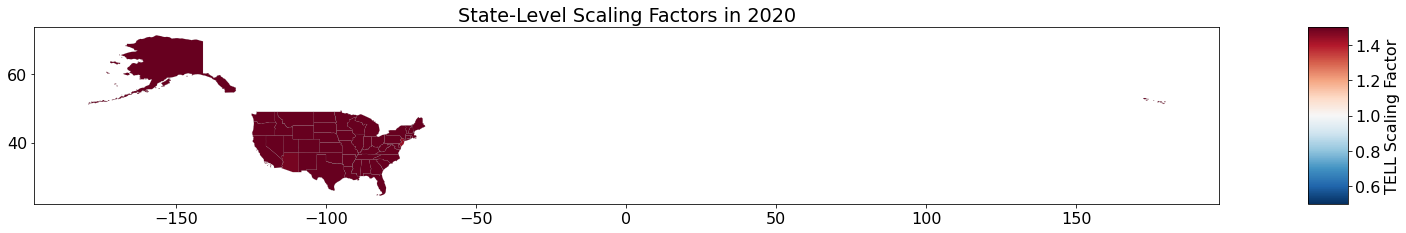

In [26]:
# Set the data input and output directories:
data_input_dir = os.path.join(current_dir, 'outputs', 'forward_output')
image_output_dir = os.path.join(current_dir, r'outputs', r'image_output')
shapefile_input_dir = raw_data_dir

# Set the year of TELL output to visualize:
year_to_plot = '2020'

# Choose whether or not to save the images and set the image resolution:
save_images = 0 # (1 = Yes)
image_resolution = 150 # (dpi)

sample_state = 'California'
sample_ba = 'ERCO'

# If you want to save the images, check that the image output directory exist and if not then create it:
if save_images == 1:
   if os.path.exists((image_output_dir + year_to_plot)) == False:
      os.mkdir((image_output_dir + year_to_plot))

# Plot a map of the state scaling factors:
tell.plot_state_scaling_factors(shapefile_input_dir, 
                                data_input_dir, 
                                year_to_plot, 
                                save_images, 
                                image_resolution,
                                image_output_dir)

# Plot the state annual total loads from GCAM-USA and TELL:
tell.plot_state_annual_total_loads(state_summary_df, 
                                   year_to_plot, 
                                   save_images, 
                                   image_resolution, 
                                   image_output_dir)

# Plot the time-series of total hourly loads for a given state by specifying either the state name or FIPS code:
tell.plot_state_load_time_series({state}, 
                                 state_hourly_load_df, 
                                 year_to_plot, 
                                 save_images, 
                                 image_resolution,
                                 image_output_dir)

# Plot the load duration curve for a given state by specifying either the state name or FIPS code:
tell.plot_state_load_duration_curve({state}, 
                                    state_hourly_load_df, 
                                    year_to_plot, 
                                    save_images, 
                                    image_resolution,
                                    image_output_dir)

# Plot the time-series of total hourly loads for a given BA by specifying either the BA abbreviation or BA number:
tell.plot_ba_load_time_series({sample_ba}, 
                              ba_hourly_load_df, 
                              year_to_plot, 
                              save_images, 
                              image_resolution, 
                              image_output_dir)
